In [17]:
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pandas as pd
import scipy.stats as stats
from statsmodels.regression.mixed_linear_model import MixedLM
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

### Question 1

**Single Factor Studies - ANOVA Model II**

Random Cell Means Model: $Y_{ij} = \mu_{i} + \epsilon_{ij}$

- $\mu_i$ are independent $N(\mu_., \sigma_\mu^2)$
- $\epsilon_{ij}$ are independent $N(0, \sigma^2)$
- $\mu_i$ and $\epsilon_{ij}$ are independent random variables
- $i = 1, 2, \dots, r$ and $j = 1, 2, \dots, n$

In [18]:
data = np.array([
    [24.4, 1, 1],
    [22.6, 1, 2],
    [23.8, 1, 3],
    [22.0, 1, 4],
    [24.5, 1, 5],
    [22.3, 1, 6],
    [25.0, 1, 7],
    [24.5, 1, 8],
    [10.2, 2, 1],
    [12.1, 2, 2],
    [10.3, 2, 3],
    [10.2, 2, 4],
    [9.9, 2, 5],
    [11.2, 2, 6],
    [12.0, 2, 7],
    [9.5, 2, 8],
    [19.2, 3, 1],
    [19.4, 3, 2],
    [19.8, 3, 3],
    [19.0, 3, 4],
    [19.6, 3, 5],
    [18.3, 3, 6],
    [20.0, 3, 7],
    [19.4, 3, 8],
    [17.4, 4, 1],
    [18.1, 4, 2],
    [16.7, 4, 3],
    [18.3, 4, 4],
    [17.6, 4, 5],
    [17.5, 4, 6],
    [18.0, 4, 7],
    [16.4, 4, 8],
    [13.4, 5, 1],
    [15.0, 5, 2],
    [14.1, 5, 3],
    [13.1, 5, 4],
    [14.9, 5, 5],
    [15.0, 5, 6],
    [13.4, 5, 7],
    [14.8, 5, 8],
    [21.3, 6, 1],
    [20.2, 6, 2],
    [20.7, 6, 3],
    [20.8, 6, 4],
    [20.1, 6, 5],
    [18.8, 6, 6],
    [21.1, 6, 7],
    [20.3, 6, 8],
], dtype=np.float32)


#### 1.a



- **Null Hypothesis ($H_0$)**: The mean sodium content is the same across all brands.<br>
Variance between the brand means $var(\sigma_\mu^2)$ = 0.

- **Alternative Hypothesis ($H_1$)**: There is a difference in the mean sodium content among the brands.<br>Variance between the brand means $var(\sigma_{\mu}^2) > 0$.

**Test Statistic**
$$ F = \frac{\text{MSTR}}{\text{MSE}} $$


**Decision Rule**
- Conclude $H_0$ if $F \leq F_{1-\alpha, r-1, r(n-1)}$
- Conclude $H_1$ if $F > F_{1-\alpha, r-1, r(n-1)}$

In [19]:
# process data into categorical variables
df = pd.DataFrame(data, columns=["Sodium", "Brand", "Replicate"])
df["Brand"] = df["Brand"].astype("category")

# setup and fit OLS model
model = ols("Sodium ~ C(Brand)", data=df).fit()

# perform ANOVA decomposition using model 2
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)
print()

dfB = anova_table.at["C(Brand)", "df"]
MSTR = anova_table.at["C(Brand)", "sum_sq"] / dfB

dfW = anova_table.at["Residual", "df"]
MSE = anova_table.at["Residual", "sum_sq"] / dfW


f_calculated = MSTR / MSE
print("Calculated F-statistic: ", f_calculated)

alpha = 0.01
f_critical = stats.f.ppf(1 - alpha, dfB, dfW)
print("Critical F-statistic: ", f_critical)

if f_calculated > f_critical:
    print("\nReject null hypothesis")
else:
    print("\nFail to reject null hypothesis")

              sum_sq    df           F        PR(>F)
C(Brand)  854.529147   5.0  238.711145  1.083748e-29
Residual   30.070003  42.0         NaN           NaN

Calculated F-statistic:  238.71114463850907
Critical F-statistic:  3.488234863858266

Reject null hypothesis


From the result of the analysis above:
- F-statistic: $238.71 > 3.48$
- p-value: $1.08 \times 10^{-29} < 0.01$ 

**Conclusion**
- We reject $H_0$ and conclude $H_1$.
- There is significant evidence to suggest that the mean sodium content is not the same across all brands in the dataset.

#### 1.b

In [20]:
alpha = 0.01
overall_mean = df["Sodium"].mean()
n_total = len(df)
standard_error = np.sqrt(MSTR / n_total)

# calculate confidence intervals
t_value = stats.t.ppf(1 - alpha / 2, dfW)

confidence_interval = (
    overall_mean - t_value * standard_error,
    overall_mean + t_value * standard_error,
)

print("Overall mean: ", overall_mean)
print()
print("Confidence interval: ", confidence_interval)


Overall mean:  17.629168

Confidence interval:  (12.538081730217687, 22.720253383307703)


Mean Sodium content across all brands is within the interval (12.53 - 22.72).

#### 1.c

In [21]:
# observations per group
k = df.groupby("Brand", observed=False).size().min()

# variance between group means (sigma^2_mu)
numerator = (MSTR - MSE) / k
denominator = numerator + MSE

variance_proportion = numerator / denominator
print("Variance proportion: ", round(variance_proportion, 3))
print()

# calculate confidence intervals
left_f = stats.f.ppf(1 - (alpha / 2), dfB, dfW)
right_f = stats.f.ppf(alpha / 2, dfB, dfW)

ratio = MSTR / MSE
left = (1 / k) * (ratio * (1 / left_f) - 1)
right = (1 / k) * (ratio * (1 / right_f) - 1)

print("Lower limit: ", round(left / (1 + left), 3))
print("Upper limit: ", round(right / (1 + right), 3))

Variance proportion:  0.967

Lower limit:  0.881
Upper limit:  0.997


Variance proportion $\approx 0.967$
<br>
Interval: (0.881 - 0.997)
<br>
96.7% of the total variability in the sodium content is due to the variability between the brands.

#### 1.d

In [22]:
# fitting the model using Maximum Likelihood Estimation
ml_model = MixedLM.from_formula("Sodium ~ 1", groups="Brand", re_formula="1", data=df)
ml_result = ml_model.fit(method="lbfgs", reml=False)

# extract variance components
ml_var_components = ml_result.cov_re.iloc[0, 0]
ml_error = ml_result.scale

# calculate variance proportion
ml_quantity = ml_var_components / (ml_var_components + ml_error)
print("Estimated variance proportion (ML): ", round(ml_quantity, 3))


Estimated variance proportion (ML):  0.961


In [23]:
# fitting the model using Restricted Maximum Likelihood Estimation
df["Replicate"] = df.groupby("Brand", observed=False).cumcount() + 1

reml_model = MixedLM.from_formula("Sodium ~ 1", groups="Brand", re_formula="1", data=df)
reml_result = reml_model.fit(reml=True, method="lbfgs")

# extract variance components
reml_var_components = reml_result.cov_re.iloc[0, 0]
reml_error = reml_result.scale

# calculate variance proportion
reml_quantity = reml_var_components / (reml_var_components + reml_error)
print("Estimated variance proportion (REML): ", reml_quantity)


Estimated variance proportion (REML):  0.9674404956166446


**Results**:
- ANOVA: 96.74%
- MLE: 96.11%
- REML: 96.74%

**Conclusion:**
- ANOVA and REML yield similar results.
- MLE yields a slightly lower estimate due to potential bias.

Preferred method: Restricted Maximum Likelihood (REML).
- Provides a less biased estimate of the variance components.
- Adjusts for the degrees of freedom used by the fixed effects.
- Works well with small sample sizes.
- Focuses on random effects (brands) rather than fixed effects.

### Question 2

In [24]:
# Penicillin data from lme4 is stored in the file penicillin.csv
# Path: penicillin.csv
penicillin = pd.read_csv("penicillin.csv")

#### 2.a

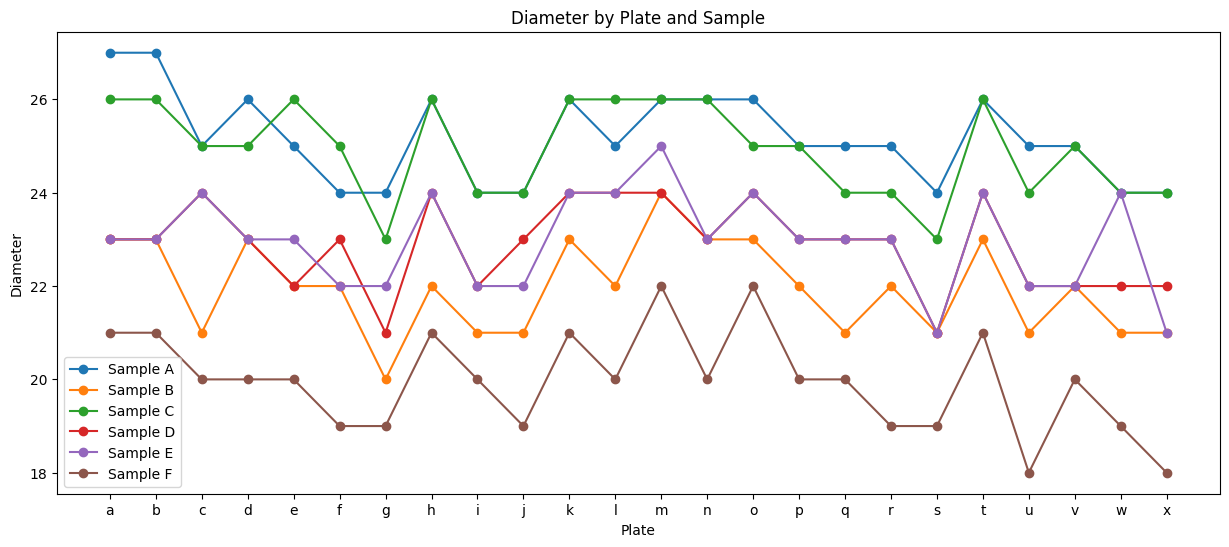

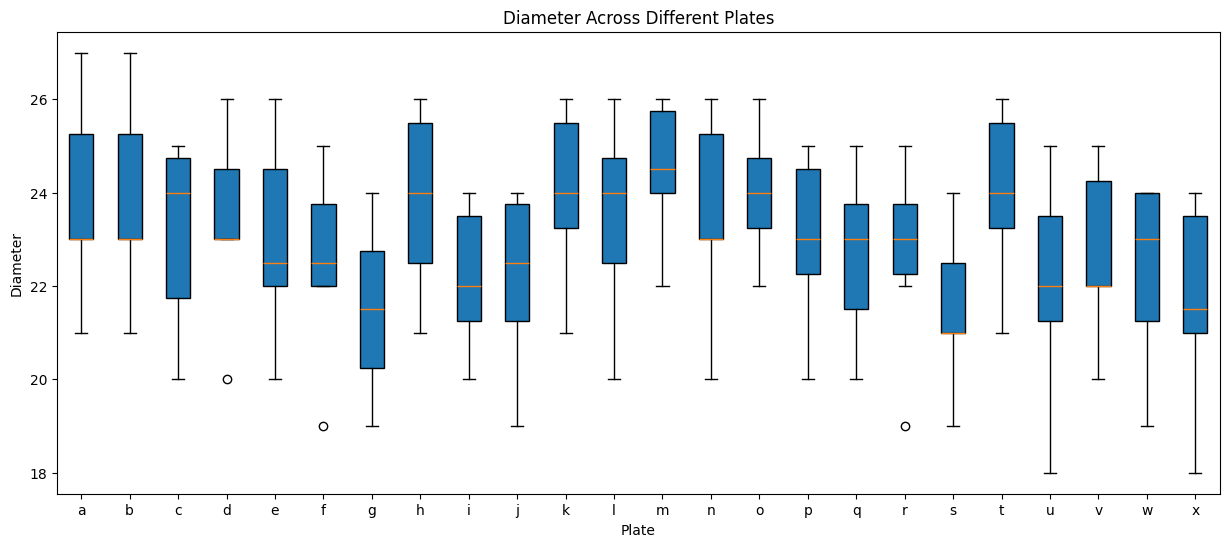

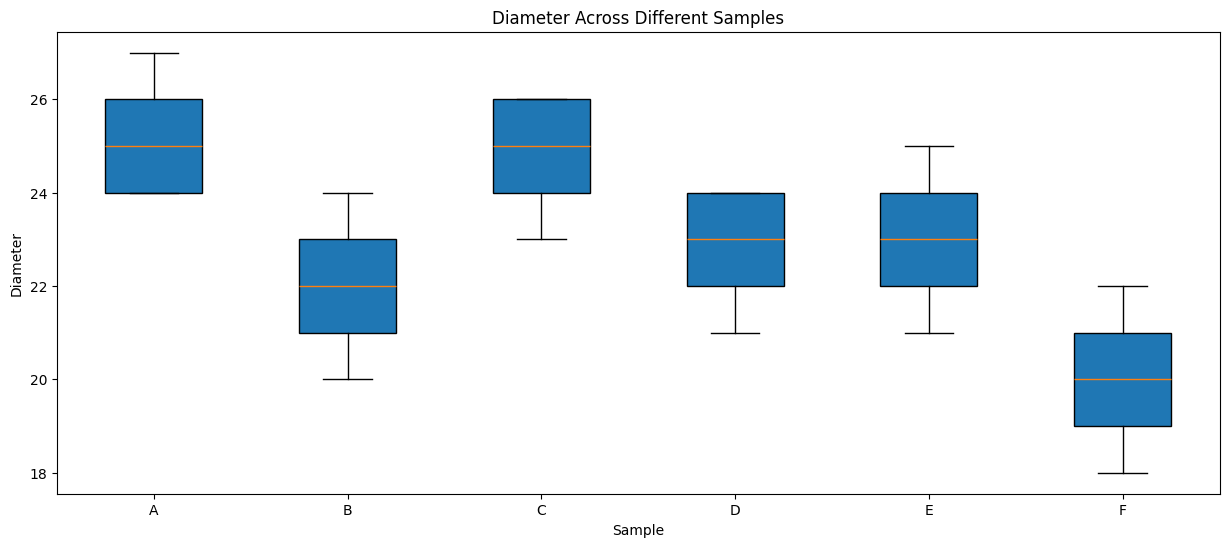

In [25]:
plt.figure(figsize=(15, 6))

# group the data by plate and sample and calculate the mean diameter
grouped_data = penicillin.groupby(["plate", "sample"]).mean().reset_index()

# plot the mean diameter
for sample in grouped_data["sample"].unique():
    sample_data = grouped_data[grouped_data["sample"] == sample]
    plt.plot(
        sample_data["plate"],
        sample_data["diameter"],
        label=f"Sample {sample}",
        marker="o",
    )

plt.title("Diameter by Plate and Sample")
plt.xlabel("Plate")
plt.ylabel("Diameter")
plt.xticks(grouped_data["plate"].unique())
plt.legend(loc="best")
plt.show()

# Plot for diameter across different plates
plt.figure(figsize=(15, 6))
plt.boxplot(
    [
        penicillin[penicillin["plate"] == plate]["diameter"]
        for plate in penicillin["plate"].unique()
    ],
    patch_artist=True,
)
plt.title("Diameter Across Different Plates")
plt.xlabel("Plate")
plt.ylabel("Diameter")
plt.xticks(
    ticks=range(1, len(penicillin["plate"].unique()) + 1),
    labels=penicillin["plate"].unique(),
)
plt.show()


# Plot for diameter across different samples
plt.figure(figsize=(15, 6))
plt.boxplot(
    [
        penicillin[penicillin["sample"] == sample]["diameter"]
        for sample in penicillin["sample"].unique()
    ],
    patch_artist=True,
)
plt.title("Diameter Across Different Samples")
plt.xlabel("Sample")
plt.ylabel("Diameter")
plt.xticks(
    ticks=range(1, len(penicillin["sample"].unique()) + 1),
    labels=penicillin["sample"].unique(),
)
plt.show()

**Observations:**
- Due to variability in diameters across different plates, the plate may have an effect on the diameter measurements.
- Due to variability in diameters across different samples, the sample might also affect the diameter measurements.

**Model Specification:**
$$ Diameter_{ij} = \mu + \text{Plate}_i + \text{Sample}_j + \epsilon_{ij}$$
- Additive model with plate and sample as random effects, and diameter as response variable.
- $ Diameter_{ij} $ is the observed diameter for the $ i $-th plate and the $ j $-th sample.
- $ \mu $ is the overall mean diameter.
- $ \text{Plate}_i $ is the random effect of the $ i $-th plate.
- $ \text{Sample}_j $ is the random effect of the $ j $-th sample.
- $ \epsilon_{ij} $ is the random error term.

**Model with interaction**
- Since we have only one observation for each plate-sample combination, it is not possible to fit a model with an interaction term.
- Without replicates, there is no way to distinguish between the variability due to the interaction of the factors and the random error.

In [26]:
# fitting the additive model
penicillin["group"] = 1
vcf = {
    "plate": "0 + C(plate)",
    "sample": "0 + C(sample)",
}

additive_model = MixedLM.from_formula(
    "diameter ~ 1",
    groups="group",
    re_formula="1",
    vc_formula=vcf,
    data=penicillin,

)
additive_result = additive_model.fit()
print(additive_result.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: diameter 
No. Observations: 144     Method:             REML     
No. Groups:       1       Scale:              0.3024   
Min. group size:  144     Log-Likelihood:     -165.4303
Max. group size:  144     Converged:          Yes      
Mean group size:  144.0                                
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    22.972    0.978 23.491 0.000 21.056 24.889
group Var     0.302                                    
plate Var     0.717    0.451                           
sample Var    3.731    4.399                           



#### 2.b

In [27]:
# full model
penicillin = pd.read_csv("penicillin.csv")
penicillin["plate"] = penicillin["plate"].astype("category")
penicillin["sample"] = penicillin["sample"].astype("category")

# setup and fit OLS model
full_model = ols("diameter ~ C(plate) + C(sample)", data=penicillin).fit()

# perform ANOVA decomposition using model 2
anova_table = sm.stats.anova_lm(full_model, typ=2)
print(anova_table)
print()

               sum_sq     df           F        PR(>F)
C(plate)   105.888889   23.0   15.223642  4.628023e-25
C(sample)  449.222222    5.0  297.089457  5.350547e-64
Residual    34.777778  115.0         NaN           NaN



**Testing for between-plate variations**
- Null Hypothesis ($H_0$): There is no variation in diameter across different plates.
<br>
- Alternative Hypothesis ($H_1$): There is significant variation in diameter across different plates.

In [28]:
# test for variation between plates
dfB = anova_table.at["C(plate)", "df"]
MSTR = anova_table.at["C(plate)", "sum_sq"] / dfB

dfW = anova_table.at["Residual", "df"]
MSE = anova_table.at["Residual", "sum_sq"] / dfW

f_calculated = MSTR / MSE
print("Calculated F-statistic: ", f_calculated)

alpha = 0.05
f_critical = stats.f.ppf(1 - alpha, dfB, dfW)
print("Critical F-statistic: ", f_critical)

if f_calculated > f_critical:
    print("\nReject null hypothesis")
else:
    print("\nFail to reject null hypothesis")

Calculated F-statistic:  15.223642172523888
Critical F-statistic:  1.6235977271552788

Reject null hypothesis


**Results from analysis of between-Plate Variation**:
- F-statistic: $15.22 > 1.62$
- p-value: $4.62 \times 10^{-25} < 0.05$

**Conclusion**:
- We reject $H_0$ and conclude $H_1$.
- The diameter variation across different plates is statistically significant.

**Testing for between-sample variations**
- Null Hypothesis ($H_0$): There is no variation in diameter across different samples.
<br>
- Alternative Hypothesis ($H_1$): There is significant variation in diameter across different samples.

In [29]:
# test for variation between samples
dfB = anova_table.at["C(sample)", "df"]
MSTR = anova_table.at["C(sample)", "sum_sq"] / dfB

dfW = anova_table.at["Residual", "df"]
MSE = anova_table.at["Residual", "sum_sq"] / dfW

f_calculated = MSTR / MSE
print("Calculated F-statistic: ", f_calculated)

alpha = 0.05
f_critical = stats.f.ppf(1 - alpha, dfB, dfW)
print("Critical F-statistic: ", f_critical)

if f_calculated > f_critical:
    print("\nReject null hypothesis")
else:
    print("\nFail to reject null hypothesis")

Calculated F-statistic:  297.0894568690076
Critical F-statistic:  2.293204561317322

Reject null hypothesis


**Results from analysis of between-Sample Variation**:
- F-statistic: $297.1 > 2.29$
- p-value: $5.35 \times 10^{-64}  < 0.01$

**Conclusion**:
- Reject $H_0$ and conclude $H_1$.
- The diameter variation across different samples is statistically significant.

#### 2.c

In [30]:
# fitting full model
penicillin["group"] = 1
vcf = {
    "plate": "0 + C(plate)",
    "sample": "0 + C(sample)",
}

additive_model = MixedLM.from_formula(
    "diameter ~ 1",
    groups="group",
    re_formula="1",
    vc_formula=vcf,
    data=penicillin,
)

# full model with MLE
full_model_ml = additive_model.fit(reml=False)

# full model with REML
full_model_reml = additive_model.fit(reml=True)

# print(full_model_ml.summary())
# print(full_model_reml.summary())

**Testing for between-plate variations using ML and REML**
- Null Hypothesis ($H_0$): There is no variation in diameter across different plates.
<br>
- Alternative Hypothesis ($H_1$): There is significant variation in diameter across different plates.

In [31]:
no_plate_model = MixedLM.from_formula(
    "diameter ~ 1",
    groups="sample",
    re_formula="1",
    data=penicillin,

)
no_plate_ml_model = no_plate_model.fit(reml=False)
no_plate_reml_model = no_plate_model.fit(reml=True)

# print(no_plate_ml_model.summary())
# print(no_plate_reml_model.summary())


# perform likelihood ratio test
# ml model
loglikelihood_full_model = full_model_ml.llf
loglikelihood_no_plate_model = no_plate_ml_model.llf
df = full_model_ml.df_modelwc - no_plate_ml_model.df_modelwc

# chi-square test
lr = -2 * (loglikelihood_no_plate_model - loglikelihood_full_model)
p_value = 1 - stats.chi2.cdf(lr, df)

print("P-value using ML method: ", p_value)
if p_value < 0.05:
    print("Reject null hypothesis")
else:
    print("Fail to reject null hypothesis")
print()

# reml model
loglikelihood_full_model = full_model_reml.llf
loglikelihood_no_plate_model = no_plate_reml_model.llf
df = full_model_reml.df_modelwc - no_plate_reml_model.df_modelwc

# chi-square test
lr = -2 * (loglikelihood_no_plate_model - loglikelihood_full_model)
p_value = 1 - stats.chi2.cdf(lr, df)

print("P-value using REML method: ", p_value)
if p_value < 0.05:
    print("Reject null hypothesis")
else:
    print("Fail to reject null hypothesis")

P-value using ML method:  0.0
Reject null hypothesis

P-value using REML method:  0.0
Reject null hypothesis


**Results from analysis of between-plate Variation (ML and REML method)**:
- p-value: $0 < 0.05$

**Conclusion**:
- Reject $H_0$ and conclude $H_1$.
- The diameter variation across different plate is statistically significant.

**Testing for between-sample variations using ML and REML**
- Null Hypothesis ($H_0$): There is no variation in diameter across different samples.
<br>
- Alternative Hypothesis ($H_1$): There is significant variation in diameter across different samples.

In [32]:
no_sample_model = MixedLM.from_formula(
    "diameter ~ 1",
    groups="plate",
    re_formula="1",
    data=penicillin,
)

no_sample_ml_model = no_sample_model.fit(reml=False)
no_sample_reml_model = no_sample_model.fit(reml=True)

# print(no_sample_ml_model.summary())
# print(no_sample_reml_model.summary())

# perform likelihood ratio test
# ml model
loglikelihood_full_model = full_model_ml.llf
loglikelihood_no_sample_model = no_sample_ml_model.llf
df = full_model_ml.df_modelwc - no_sample_ml_model.df_modelwc

# chi-square test
lr = -2 * (loglikelihood_no_sample_model - loglikelihood_full_model)
p_value = 1 - stats.chi2.cdf(lr, df)

print("P-value using ML method: ", p_value)
if p_value < 0.05:
    print("Reject null hypothesis")
else:
    print("Fail to reject null hypothesis")
print()


# reml model
loglikelihood_full_model = full_model_reml.llf
loglikelihood_no_sample_model = no_sample_reml_model.llf
df = full_model_reml.df_modelwc - no_sample_reml_model.df_modelwc

# chi-square test
lr = -2 * (loglikelihood_no_sample_model - loglikelihood_full_model)
p_value = 1 - stats.chi2.cdf(lr, df)

print("P-value using REML method: ", p_value)
if p_value < 0.05:
    print("Reject null hypothesis")
else:
    print("Fail to reject null hypothesis")

P-value using ML method:  0.0
Reject null hypothesis

P-value using REML method:  0.0
Reject null hypothesis


**Results from analysis of between-plate Variation (ML and REML method)**:
- p-value: $0 < 0.05$

**Conclusion**:
- Reject $H_0$ and conclude $H_1$.
- The diameter variation across different samples is statistically significant.